In [37]:
# import library and load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [38]:
# load dataset
data_path = '../../data/processed/data_cleaned_scaled_onehot.csv' 
data = pd.read_csv(data_path)

# form features and target
X = data.drop(['Target'], axis=1)
y = data['Target']

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Adjust the class distribution to ensure the model learns adequately about the minority class
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [39]:
# hyper parameter search for k-NN classifier
param_grid = {
    'n_neighbors': range(1, 120),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, n_jobs=-1, scoring='roc_auc', cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)
best_k = grid_search.best_params_['n_neighbors']

{'metric': 'manhattan', 'n_neighbors': 77, 'weights': 'distance'}
0.8952435826508112


Threshold: 0.05 Recall: 0.9823 Accuracy: 0.4746
Threshold: 0.06 Recall: 0.9735 Accuracy: 0.5184
Threshold: 0.07 Recall: 0.9513 Accuracy: 0.5565
Threshold: 0.08 Recall: 0.9381 Accuracy: 0.6045
Threshold: 0.09 Recall: 0.9248 Accuracy: 0.6483
Threshold: 0.10 Recall: 0.9071 Accuracy: 0.6780
Threshold: 0.11 Recall: 0.8982 Accuracy: 0.7105
Threshold: 0.12 Recall: 0.8805 Accuracy: 0.7288
Threshold: 0.13 Recall: 0.8628 Accuracy: 0.7401
Threshold: 0.14 Recall: 0.8584 Accuracy: 0.7514
Threshold: 0.15 Recall: 0.8407 Accuracy: 0.7613
Threshold: 0.16 Recall: 0.8319 Accuracy: 0.7768
Threshold: 0.17 Recall: 0.8186 Accuracy: 0.7853
Threshold: 0.18 Recall: 0.7965 Accuracy: 0.7895
Threshold: 0.19 Recall: 0.7965 Accuracy: 0.8051
Threshold: 0.20 Recall: 0.7788 Accuracy: 0.8107
Threshold: 0.21 Recall: 0.7699 Accuracy: 0.8192
Threshold: 0.22 Recall: 0.7655 Accuracy: 0.8319
Threshold: 0.23 Recall: 0.7566 Accuracy: 0.8404
Threshold: 0.24 Recall: 0.7434 Accuracy: 0.8418


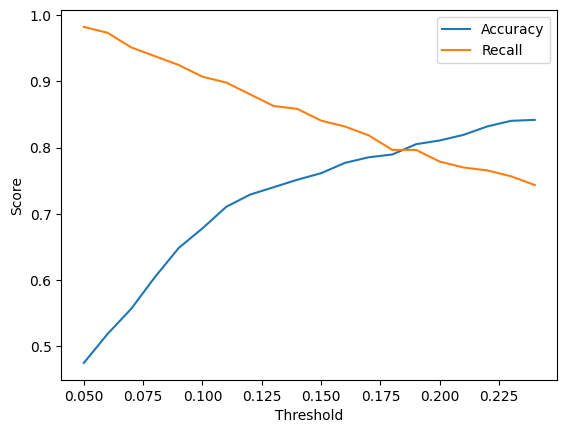

In [40]:
# hyper parameter search for decision threshold

#split data into training and validation set
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance', metric='manhattan')
knn.fit(X_train_sub, y_train_sub)

accuracies = []
recalls = []
for threshold in np.arange(0.05, 0.25, 0.01):
    y_pred = knn.predict_proba(X_val)[:, 1]
    y_pred = (y_pred > threshold).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, f1_score, _ = classification_report(y_val, y_pred, output_dict=True)['1'].values()
    print('Threshold: {:.2f} Recall: {:.4f} Accuracy: {:.4f}'.format(threshold, recall, accuracy))
    accuracies.append(accuracy)
    recalls.append(recall)

plt.plot(np.arange(0.05, 0.25, 0.01), accuracies, label='Accuracy')
plt.plot(np.arange(0.05, 0.25, 0.01), recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()


In [41]:
# cross validation to evaluate model consistently
knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance', metric='manhattan')
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
print("accuracy mean:", scores.mean(), "accuracy std:", scores.std())

scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='recall')
print("recall mean:", scores.mean(), "recall std:", scores.std())

accuracy mean: 0.8174621820535565 accuracy std: 0.0068359611792011745
recall mean: 0.44162895927601814 recall std: 0.02471764757239396


In [42]:
# using K-NN to predict the target
knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance', metric='manhattan')
knn.fit(X_train, y_train)
y_pred_proba = knn.predict_proba(X_test)
threshold = 0.15
y_pred = (y_pred_proba[:, 1] > threshold).astype(int)

# accuracy, precision, recall, f1-score

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = classification_report(y_test, y_pred, output_dict=True)['1'].values()

print("recall", recall)
print("accuracy", accuracy)
print("f1_score", f1_score)
print("precision", precision)

# confusion matrix
print("")
print("confusion matrix: [TP, FP], [FN, TN]")
print(confusion_matrix(y_test, y_pred))

recall 0.8449367088607594
accuracy 0.7649717514124293
f1_score 0.7196765498652291
precision 0.6267605633802817

confusion matrix: [TP, FP], [FN, TN]
[[410 159]
 [ 49 267]]


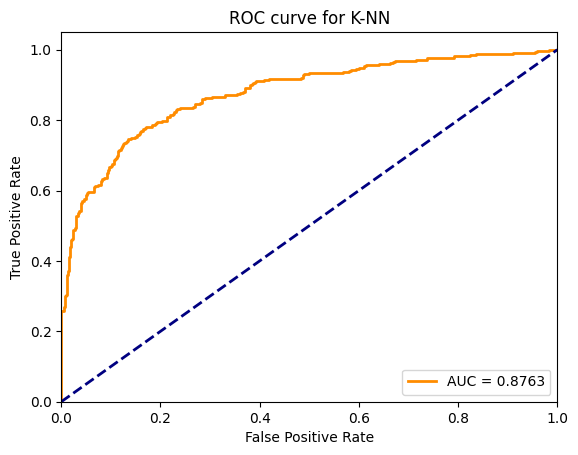

In [43]:
# draw roc curve and calculate auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.4f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for K-NN')
plt.legend(loc='lower right')
plt.show()
